<a href="https://colab.research.google.com/github/srinirama/Convolutional-Neural-Network-Industry-Applications/blob/main/Using-CNNs-with-Flowers-Images/Working_With_Flower_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Images

In this notebook, we will go through the end-to-end pipeline of training conv nets, i.e. organising the data into directories, preprocessing, data augmentation, model building etc.  

In [13]:
!ls sample_data

!mkdir -p ~/.kaggle/

anscombe.json		      kaggle.json	     README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


In [14]:
# For downloading the dataset
# Go to Kaggle.com -> My Account -> Create new API Token -> Upload kaggle.json in Jupyter Home/CNN/
!cp sample_data/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
#!kaggle config set -n proxy -v http://10.140.0.96:3128
!kaggle datasets download -d alxmamaev/flowers-recognition



  0%|          | 0.00/225M [00:00<?, ?B/s]
  0%|          | 1.00M/225M [00:00<00:36, 6.42MB/s]
  1%|          | 2.00M/225M [00:00<00:29, 7.88MB/s]
  1%|1         | 3.00M/225M [00:00<00:28, 8.09MB/s]
  2%|1         | 4.00M/225M [00:00<00:26, 8.83MB/s]
  2%|2         | 5.00M/225M [00:00<00:31, 7.21MB/s]
  3%|2         | 6.00M/225M [00:00<00:34, 6.69MB/s]
  3%|3         | 7.00M/225M [00:00<00:30, 7.42MB/s]
  4%|3         | 8.00M/225M [00:01<00:28, 7.98MB/s]
  4%|4         | 10.0M/225M [00:01<00:25, 8.66MB/s]
  5%|4         | 11.0M/225M [00:01<00:25, 8.87MB/s]
  5%|5         | 12.0M/225M [00:01<00:27, 7.99MB/s]
  6%|6         | 14.0M/225M [00:01<00:24, 8.94MB/s]
  7%|7         | 16.0M/225M [00:01<00:23, 9.41MB/s]
  8%|7         | 17.0M/225M [00:02<00:23, 9.45MB/s]
  8%|8         | 19.0M/225M [00:02<00:22, 9.73MB/s]
  9%|8         | 20.0M/225M [00:02<00:22, 9.69MB/s]
  9%|9         | 21.0M/225M [00:02<00:21, 9.73MB/s]
 10%|9         | 22.0M/225M [00:02<00:21, 9.88MB/s]
 10%|#         | 23.

In [3]:
!unzip flowers-recognition.zip
!rm flowers-recognition.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
# note that pip install skimage might throw an error, rather use this
#!pip install scikit-image

In [4]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

##  Image Augmentation & Preprocessing

In the following section, we'll look at some common image preprocessing techniques.

### Understanding images and channels

As these images are RGB images they would constitute three channels - one for each of the color channels

In [6]:
!ls ./flowers

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# path to your dataset
DATASET_PATH = './flowers'
flowers_cls = ['daisy', 'rose']

We'll now use the `glob` module of python to <a href="https://en.wikipedia.org/wiki/Glob_(programming)">glob</a> through the directory where the data is stored, i.e. to walk through the directory, subdirectories and the files. It uses regular expressions to access files having names matching some pattern. In our case, we want to access all the files in the path `flowers/rose/` and `flowers/daisy/`, so we'll just use the regex `*` (used as a 'wildcard' to catch everything). 

An example of how the glob module works is given below - you first join the base directory path with the subdirectory (e.g. `flowers/rose/`) and then `glob` through it to access all the individual files (images here).

In [8]:
# globbing example
# help(glob)
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
print(flower_path)

# glob through the directory (returns a list of all file paths)
flower_path = glob.glob(flower_path)
print(flower_path[65]) # access an individual file

./flowers\rose\*
./flowers\rose\14597445311_8acb60247e.jpg


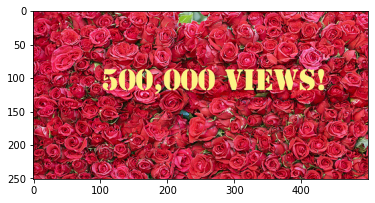

In [23]:
# run this block multiple times to look at some randomly chosen images of roses
rand_index = random.randint(0, len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

In [33]:
rand_index

363

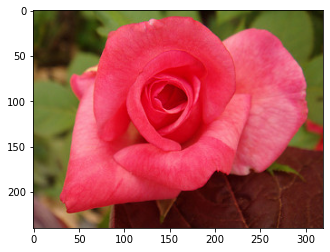

In [9]:
# plot a sample image
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
flower_path = glob.glob(flower_path)

# access some element (a file) from the list
image = io.imread(flower_path[363])
plt.imshow(image)

In [10]:
print(image.shape)

(240, 320, 3)


Text(0.5, 0.98, 'Different Channels of Image')

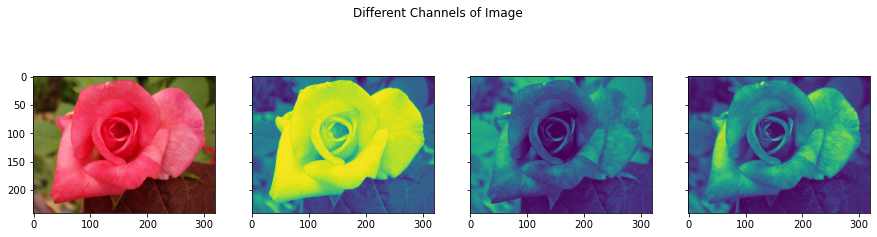

In [11]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

In [29]:
help(ax2.imshow)

Help on method imshow in module matplotlib.axes._axes:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Display data as an image; i.e. on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. Note: For actually displaying
    a grayscale image set up the color mapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The values are mapped to
          colors using normalization and a colormap. See parameters *norm*,
          *cmap*, *vmin*, *vmax*.
 

Bright should be Red Channel

## Morphological Transformations

> Indented block



### Thresholding

One of the simpler operations where we take all the pixels whose intensities are above a certain threshold, and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a *binary image*.

**the pixels having value less than the threshold are converted to zero. This results in a binary image.**

- Bright are Ones
- Dark are Zeros


What is the reason for choosing 125 as a threshold?


Arbitrary heuristic measure halfway between 1 and 255 (the range of image pixel)

✓ Correct
Feedback:
You can definitely choose a different value, based on your use case. For example, sometimes you may be biased towards higher pixel values (e.g. low light pictures) - in that case, use a higher threshold.

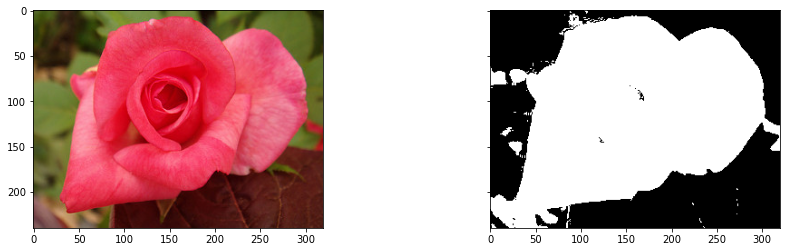

In [12]:
# bin_image will be a (240, 320) True/False array
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')



### Erosion, Dilation, Opening & Closing

**Erosion** shrinks bright regions and enlarges dark regions. **Dilation** on the other hand is exact opposite side - it shrinks dark regions and enlarges the bright regions. 

**Opening** is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

**Closing** is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

All these can be done using the `skimage.morphology` module. The basic idea is to have a **circular disk** of a certain size (3 below) move around the image and apply these transformations using it.

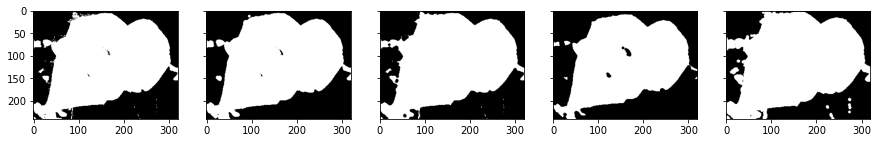

In [13]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem

# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

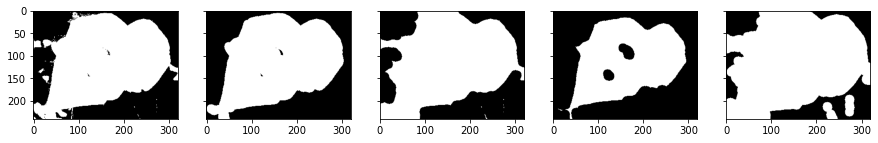

In [16]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem

# use a disk of radius 5
selem = selem.disk(10)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

<font color="red">Opening refers to:

Erosion followed by dilation

✓ Correct
Feedback:
Easy way to remember this - opening is used to "open up" the light, hence the last step will be to enlarge the bright parts 
(the word "dilation" refers to enlarging)
</font>

- Opening or Closing?
 - Which one of these will I use to remove dark spots? (imagine a photo taken in the rain - it can sometimes have dark spots!)
 
 
 
Ans: Closing

✓ Correct
Feedback:
Closing removes dark spots by performing Dilation followed by Erosion!

Functionalities of morphological transformations
Let’s say I want to remove some black spots inside a shape. Which of the following can you perform?



Dilation

✓ Correct
Feedback:
Dilation shrinks dark spots, enlarges bright spots

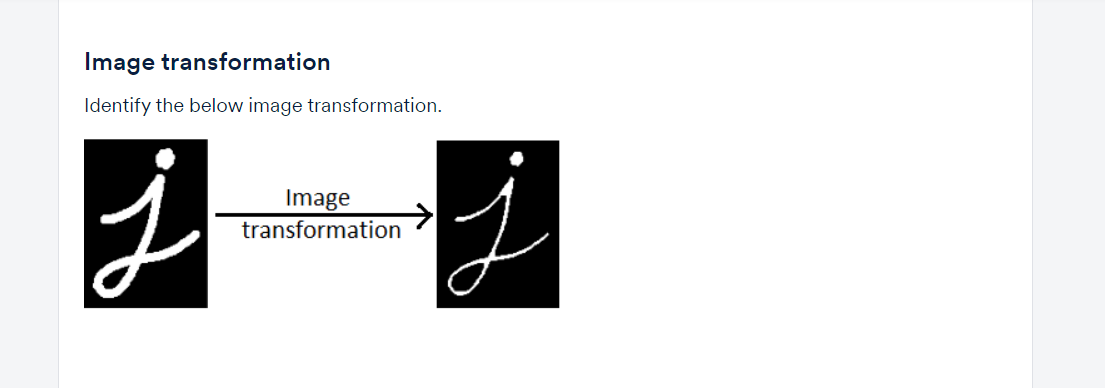




Erosion

✓ Correct
Feedback:
**Erosion shrinks bright spots**, enlarges dark spots. You can see that the width of the alphabet 'j' has been reduced. 

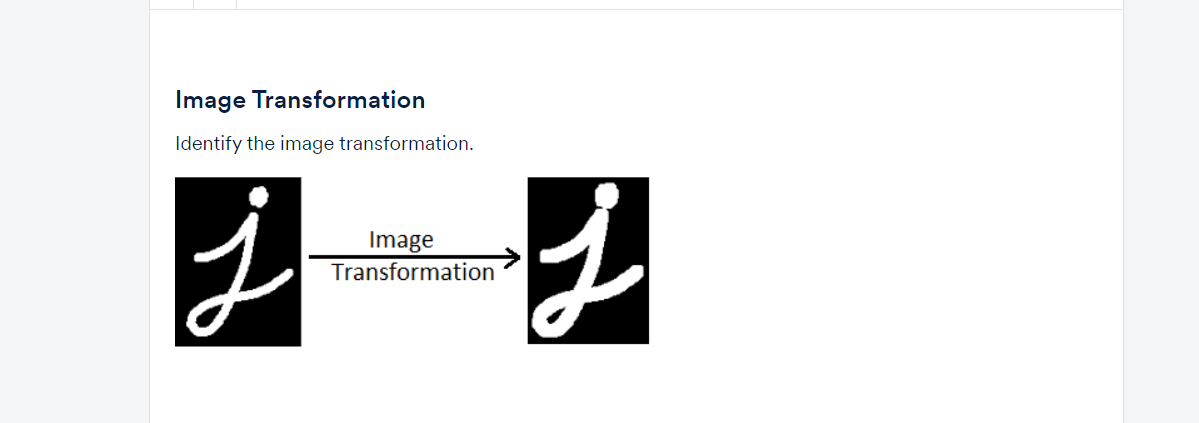




Dilaton

✓ Correct
Feedback:
**Dilation** shrinks dark spots, **enlarges bright spots**. You can see that the width of the alphabet 'j' has been increased. 

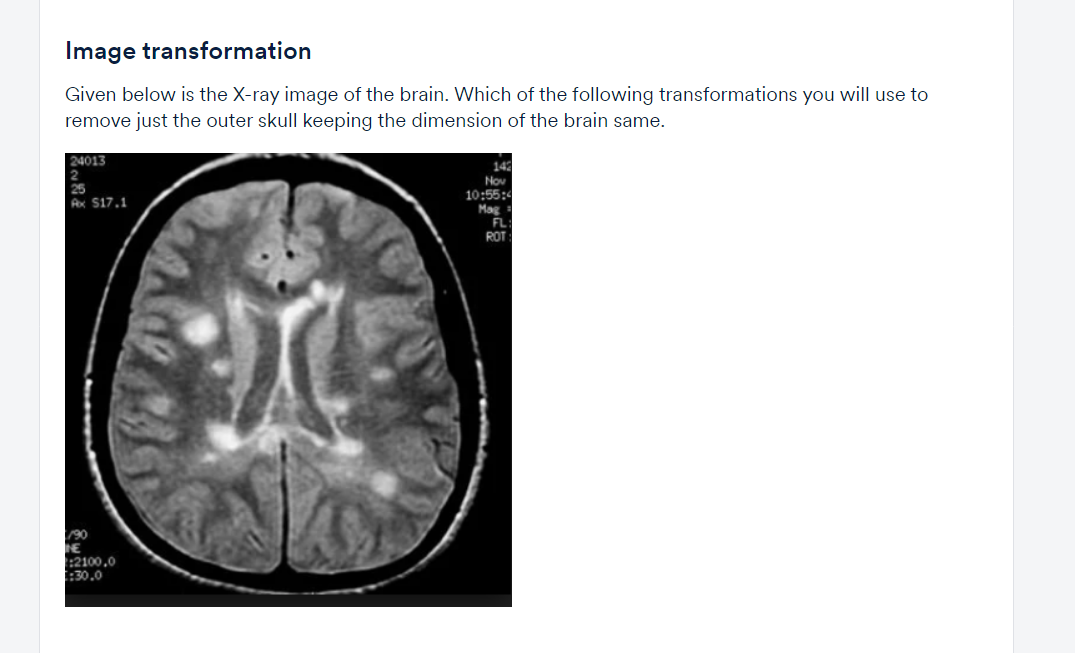



Opening

✓ Correct
Feedback:
Here, Opening will be used. First, erosion will be used to remove the white skull portion. But this will also shrink the size of the brain. To make the dimension of the brain same, dilation will be used.

## Normalisation 

Normalisation is the most crucial step in the pre-processing part.
Image needs to be scaled between 0-255. but its not always the case

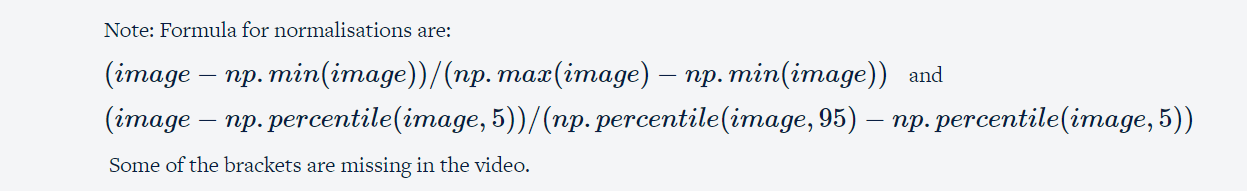

There are multiple ways to normalise images which we will be talking about.


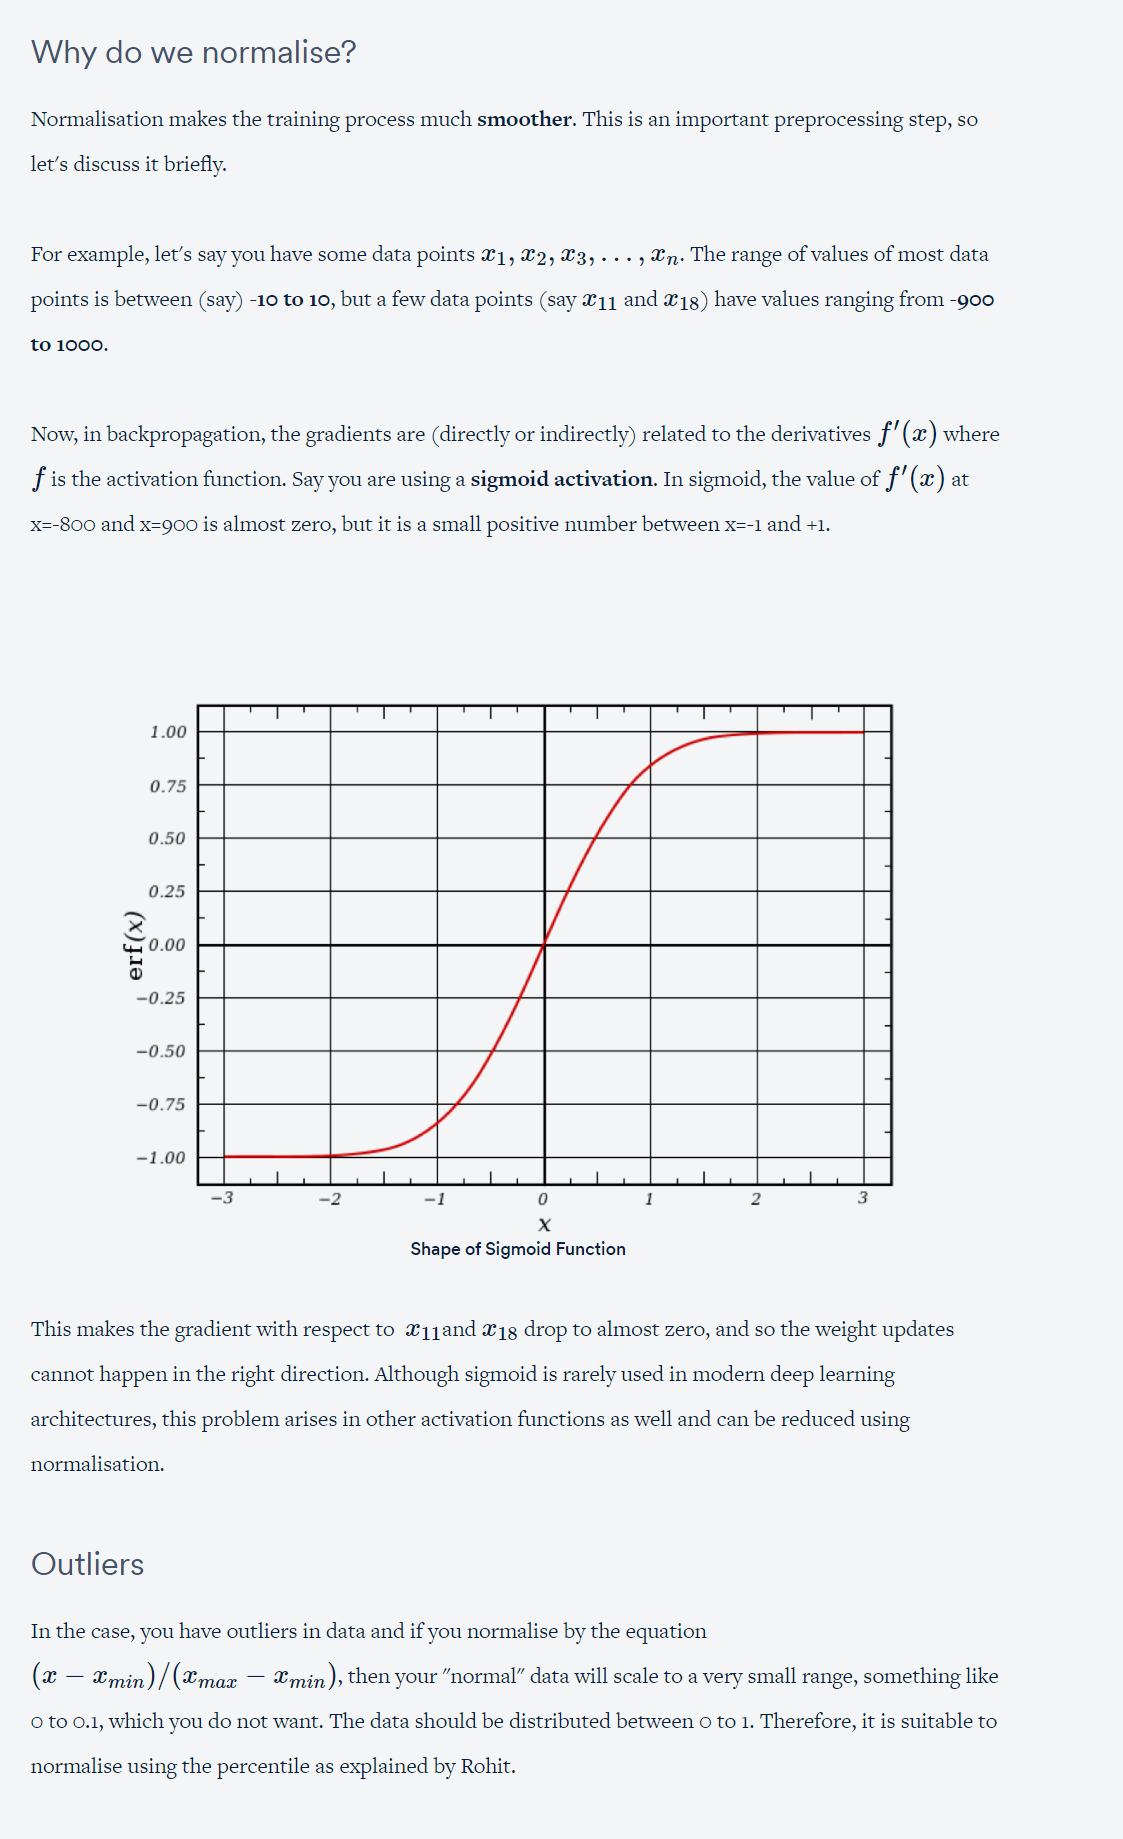

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


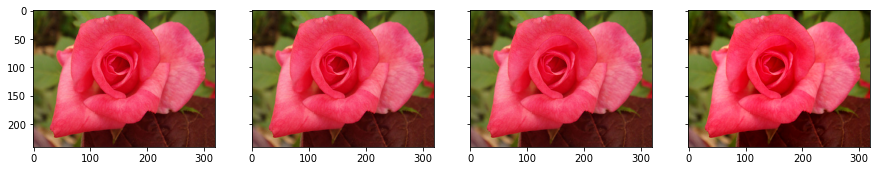

In [17]:
norm1_image = image/255
norm2_image = (image - np.min(image))/(np.max(image) - np.min(image))
norm3_image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

Which of these are reasons to do normalisation?


Contrast and lighting conditions

✓ Correct
Feedback:
We need to account for variation in pictures, or different settings of machines taking images


Gradient Propagation

✓ Correct
Feedback:
Normalised images make for much better gradient propagation

Range-based normalisation
Which of the following could be the need for normalisation based on the max/min values instead of just dividing it by 255?


It finds better application in non-natural images.

✓ Correct
Feedback:
Non-natural images are usually specific to the range of the values that they lie between - dividing by 255 distorts the data of this image (e.g. some MRI regions have pixels that never reach 255, and hence 255 is an arbitrary value.)

Normalisation
Which of the following is a more suitable range for input data in the case we use a neural network with ReLU activation?


0 to 1

✓ Correct
Feedback:
0 to 1 range is preferred in the case we use a neural network with ReLU activation as it discards the data below the value 0. 

Outliers
Which of the following are the suitable transformations in the case you have outliers in the input data?

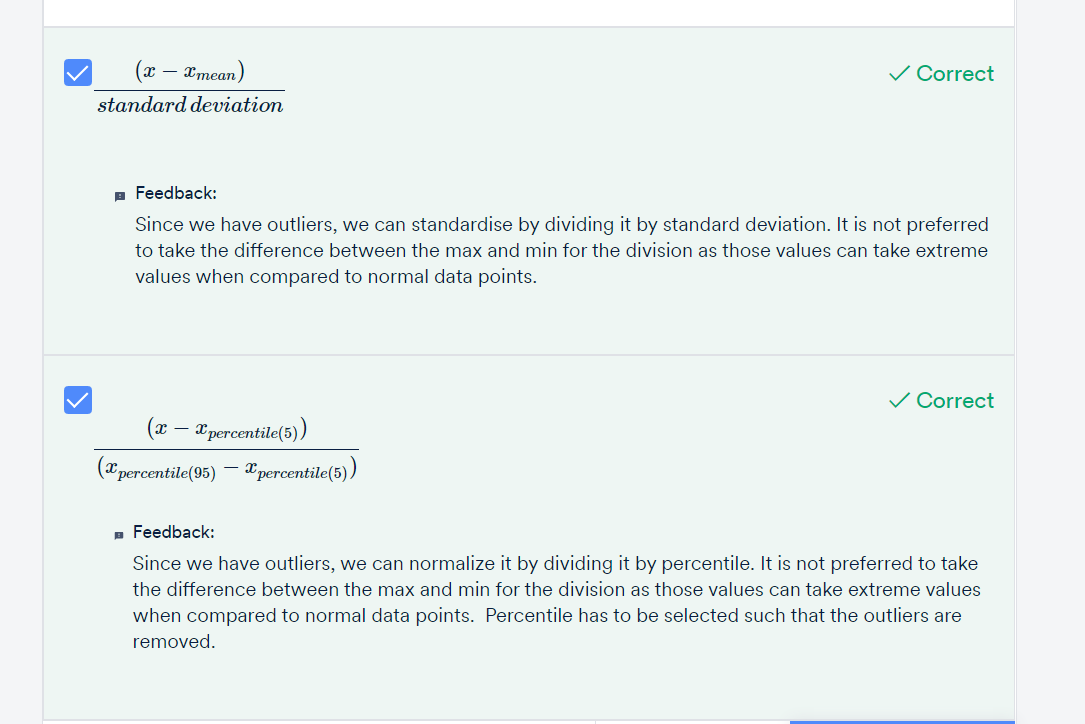 

## Augmentations

Insufficient data
This brings us to the next aspect of data pre-processing - data augmentation. Many times, the quantity of data that we have is not sufficient to perform the task of classification well enough. In such cases, we perform data augmentation.

As an example, if we are working with a dataset of classifying gemstones into their different types, we may not have enough number of images (since high-quality images are difficult to obtain). In this case, we can perform augmentation to increase the size of your dataset.


As you know that pooling increases the invariance. **If a picture of a dog is in the top left corner of an image, with pooling, you would be able to recognise if the dog is in little bit left/right/up/down around the top left corner. But with training data consisting of data augmentation like flipping, rotation, cropping, translation, illumination, scaling, adding noise etc., the model learns all these variations. This significantly boosts the accuracy of the model. So, even if the dog is there at any corner of the image, the model will be able to recognise it with high accuracy**

There are multiple types of augmentations possible. The basic ones transform the original image using one of the following types of transformations:

1. Linear transformations
2. Affine transformations

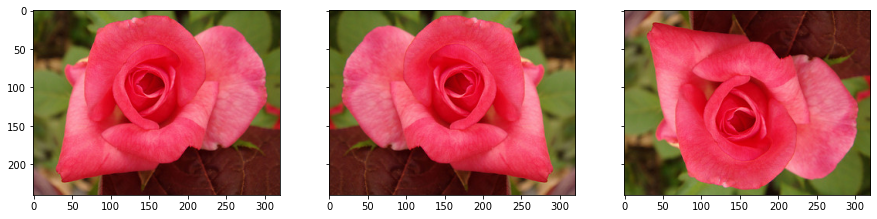

In [19]:
from skimage import transform

# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image, image_flipr, image_flipud])

In [ ]:
# help(transform)

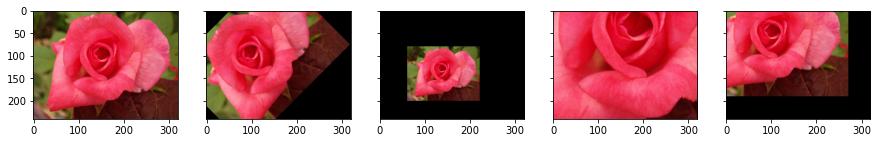

In [21]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(image, rot_matrix)

# scaling 
scale_transforms = transform.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = transform.warp(image, scale_matrix)

scale_transforms = transform.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = transform.warp(image, scale_matrix)

# translation
transaltion_transforms = transform.AffineTransform(translation=(50, 50))
translated_image = transform.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


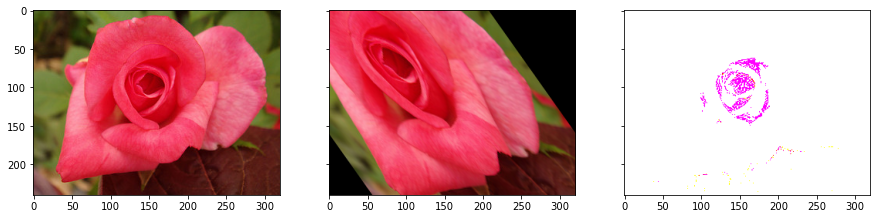

In [27]:
# shear transforms
shear_transforms = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = transform.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

C:/Users/raman/OneDrive/Pictures/*.jpg
C:/Users/raman/OneDrive/Pictures\poornima.jpg


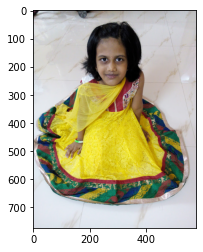

In [39]:
# globbing example
# help(glob)
test_path = "C:/Users/raman/OneDrive/Pictures/*.jpg"
print(test_path)

# glob through the directory (returns a list of all file paths)
test_path = glob.glob(test_path)
print(test_path[0]) # access an individual file

# run this block multiple times to look at some randomly chosen images of roses
poornima_image = io.imread(test_path[0])
plt.imshow(poornima_image)

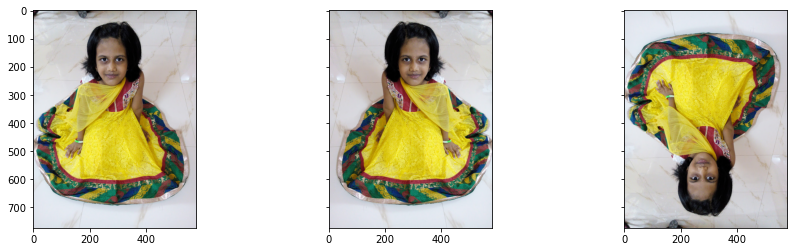

In [40]:
from skimage import transform

# flip left-right, up-down
poornima_image_flipr = np.fliplr(poornima_image)
poornima_image_flipud = np.flipud(poornima_image)

plot_image([poornima_image, poornima_image_flipr, poornima_image_flipud])

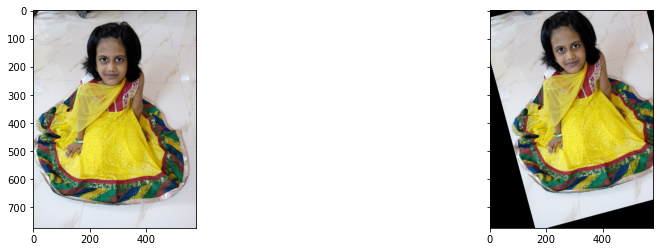

In [44]:
# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(15))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(poornima_image, rot_matrix)

plot_image([poornima_image,rot_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


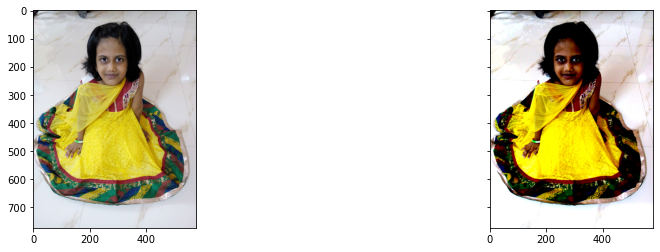

In [45]:
norm3_image = (poornima_image - np.percentile(poornima_image,25))/ (np.percentile(poornima_image,75) - np.percentile(poornima_image,25))

plot_image([poornima_image,norm3_image])

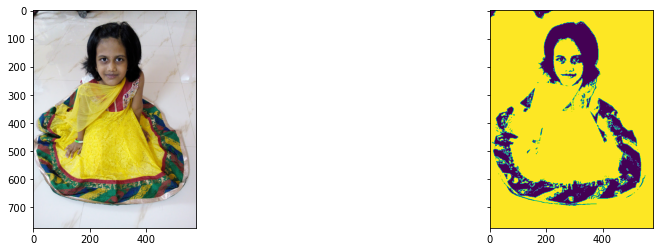

In [63]:
bin_image = poornima_image[:, :, 0] > 115
#plot_image([image, bin_image], cmap='YlGn')
plot_image([poornima_image,bin_image])

In [64]:
import tensorflow as tf

# First, define the shifting transformations
shift_x, shift_y = poornima_image.shape[0]/2, poornima_image.shape[1]/2
matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])

# Then, perform rotation transform
rot_transforms =  tf.AffineTransform(rotation=np.deg2rad(90))

# Then, perform the scaling transform with 4X zoom-in
scale_transforms = tf.AffineTransform(scale=(0.25, 0.25))

# Add up the transforms
rot_plus_scale_matrix = matrix_to_topleft + rot_transforms + scale_transforms + matrix_to_center

# Finally, apply the added-up transformation 
final_image = tf.warp(poornima_image, rot_plus_scale_matrix)

# Plot the image
plot_image([poornima_image,final_image])

AttributeError: module 'tensorflow' has no attribute 'SimilarityTransform'

<hr>

# Network Building

Let's now build the network. We'll import the resnet architecture from the module `resnet.py`.

In [ ]:
import resnet

# specify image size and channels
img_channels = 3
img_rows = 100
img_cols = 100

# number of classes
nb_classes = 2

### Data Generator ###

Let's now set up the **data generator**. The code below sets up a custom data generator which is slightly different than <a href="https://keras.io/preprocessing/image/">the one that comes with the keras API</a>. The reason to use a custom generator is to be able to modify it according to the problem at hand (customizability). 


We won't be going through the entire code step-by-step in the lectures, though the code is explained below.

To start with, we have the training data stored in $n$ directories (if there are $n$ classes). For a given batch size, we want to generate batches of data points and feed them to the model.


The first `for` loop 'globs' through each of the classes (directories). For each class, it stores the path of each image in the list `paths`. In training mode, it subsets `paths` to contain the first 80% images; in validation mode it subsets the last 20%. In the special case of an ablation experiment, it simply subsets the first `ablation` images of each class.

We store the paths of all the images (of all classes) in a combined list `self.list_IDs`. The dictionary `self.labels` contains the labels (as key:value pairs of `path: class_number (0/1)`).

After the loop, we call the method `on_epoch_end()`, which creates an array `self.indexes` of length `self.list_IDs` and shuffles them (to shuffle all the data points at the end of each epoch).

The `_getitem_` method uses the (shuffled) array `self.indexes` to select a `batch_size` number of entries (paths) from the path list `self.list_IDs`. 

Finally, the method `__data_generation` returns the batch of images as the pair X, y where X is of shape `(batch_size, height, width, channels)` and y is of shape `(batch size, )`. Note that `__data_generation` also does some preprocessing - it normalises the images (divides by 255) and crops the center 100 x 100 portion of the image. Thus, each image has the shape `(100, 100, num_channels)`. If any dimension (height or width) of an image less than 100 pixels, that image is deleted.


In [ ]:
import numpy as np
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

### Running Ablation Experiments 

Before training the net on the entire dataset, you should always try to first run some experiments to check whether the net is fitting on a small dataset or not. 

#### Checking that the network is 'working'

The first part of building a network is to get it to run on your dataset. Let's try fitting the net on only a few images and just one epoch. Note that since `ablation=100` is specified, 100 images of each class are used, so total number of batches is `np.floor(200/32)` = 6. 

Note that the `DataGenerator`  class 'inherits' from the `tf.keras.utils.Sequence` class, so it has all the functionalities of the base `tf.keras.utils.Sequence` class (such as the `model.fit_generator` method).

<HR>
Ablation Experiments
If you use ablation=50 with a batch size of 32, how many batches will be used for training? Refer to the notebook to understand how ablation is used in the DataGenerator.


3

✓ Correct
Feedback:
With ablation 50, 50 images of each class will be used, hence 100 total images will be used for training. Since batch size is 32, the number of batches will be np.floor(100/32) = 3.

In [ ]:
# using resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit(training_generator, epochs=1, validation_data=validation_generator)

6/6 [==============================] - 2s 376ms/step - loss: 1.7539 - accuracy: 0.5781 - val_loss: 2.1851 - val_accuracy: 0.5469


### Overfitting on the Training Data

<font color="red">
    
    To summarise, a good test of any model is to check whether it can overfit on the training data (i.e. the training loss consistently reduces along epochs). This technique is especially useful in deep learning because most deep learning models are trained on large datasets, and if they are unable to overfit a small version, then they are unlikely to learn from the larger version.

- During training, sometimes you may get NaN as a loss instead of some finite number. 
- This denotes that the output value predicted by the model is very high, which results in high loss value. 
- This causes exploding gradient problem. 
- The problem could be a high learning rate and to overcome, you can use SGD Optimiser.
- Although the adaptive methods (Adam, RMSProp etc.) have better training performance, they can generalise worse than SGD.
- Furthermore, you can also play with some of the initialisation techniques like Xavier initialisation, He initialisation etc. - Last attempt to change the architecture of the network if the problem does not get solved.
    Mostly architecture being proven doesn't require any changes
    </font>

Let's now perform another important step which should be done before training the full-fledged model-  trying to **deliberately overfit the model** on a small dataset.

We'll use ablation=100 (i.e. training on 100 images of each class), so it is still a very small dataset, and we will use 20 epochs. In each epoch, 200/32=6 batches will be used.

In [ ]:
# resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

# generators
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit
model.fit(training_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
6/6 [==============================] - 2s 332ms/step - loss: 1.6467 - accuracy: 0.5938 - val_loss: 3.9061 - val_accuracy: 0.5052
Epoch 2/20
6/6 [==============================] - 1s 234ms/step - loss: 1.5114 - accuracy: 0.7708 - val_loss: 2.8449 - val_accuracy: 0.5417
Epoch 3/20
6/6 [==============================] - 1s 230ms/step - loss: 1.4432 - accuracy: 0.8073 - val_loss: 2.4882 - val_accuracy: 0.5677
Epoch 4/20
6/6 [==============================] - 1s 225ms/step - loss: 1.3974 - accuracy: 0.8177 - val_loss: 2.0298 - val_accuracy: 0.5885
Epoch 5/20
6/6 [==============================] - 1s 234ms/step - loss: 1.3689 - accuracy: 0.8333 - val_loss: 1.8926 - val_accuracy: 0.5938
Epoch 6/20
6/6 [==============================] - 1s 237ms/step - loss: 1.3530 - accuracy: 0.8438 - val_loss: 1.7308 - val_accuracy: 0.6146
Epoch 7/20
6/6 [==============================] - 1s 231ms/step - loss: 1.3110 - accuracy: 0.8698 - val_loss: 1.6623 - val_accuracy: 0.6406
Epoch 8/20
6/6 [====

The results show that the training accuracy increases consistently with each epoch. The validation accuracy also increases and then plateaus out - this is a sign of 'good fit', i.e. we know that the model is at least able to learn from a small dataset, so we can hope that it will be able to learn from the entire set as well.

<font color="red">
Here, we tuned the learning rate hyperparameter and observed that a rate of 0.1 is the optimal learning rate when compared to 0.01 and 0.001. However, you know that using such a high learning rate for the entire training process is not a good idea since the loss may start to oscillate around the minima later. So, at the start of the training, we use a high learning rate for the model to learn fast, but as we train further and proceed towards the minima, we decrease the learning rate gradually.</font> 

### Hyperparameter Tuning

First let's make a list the hyper-parameters we want to tune:

1. Learning Rate & Variation + Optimisers 
2. Augmentation Techniques

The basic idea is to track the validation loss with increasing epochs for various values of a hyperparameter. 

#### Keras Callbacks ####

Before you move ahead, let's discuss a bit about **callbacks**. Callbacks are basically actions that you want to perform at specific instances of training. For example, we want to perform the action of storing the loss at the end of every epoch (the instance here is the end of an epoch).


Formally, a callback is simply a function (if you want to perform a single action), or a list of functions (if you want to perform multiple actions), which are to be executed at specific events (end of an epoch, start of every batch, when the accuracy plateaus out, etc.). Keras provides some very useful callback functionalities through the class `tf.keras.callbacks.Callback`. 

Keras has many builtin callbacks (<a href="https://keras.io/callbacks/">listed here</a>). The generic way to **create a custom callback in keras** is:


In [ ]:
# generic way to create custom callback
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In the code below, we have created a custom callback to append the loss to a list at the end of every epoch. Note that `logs` is an attribute (a dictionary) of `tf.keras.callbacks.Callback`, and we are using it to get the value of the key 'loss'. Some other keys of this dict are `acc`, `val_loss` etc.

To tell the model that we want to use a callback, we create an object of `LossHistory` called `history` and pass it to `model.fit_generator` using `callbacks=[history]`. In this case, we only have one callback `history`, though you can pass multiple callback objects through this list (an example of multiple callbacks is in the section below - see the code block of `DecayLR()`).

We highly recommend you to <a href="https://keras.io/callbacks/">read the documentation of keras callbacks here</a>. For a gentler introduction to callbacks, you can read this <a href="https://machinelearningmastery.com/check-point-deep-learning-models-keras/"> nice blog post by Jason Brownlee.</a>



Keras Callbacks
Refer to the Keras documentation of callbacks and choose all the correct statements: - https://keras.io/api/callbacks/


keras.callbacks.TerminateOnNaN() terminates training when NaN loss is encountered.

✓ Correct
Feedback:
You can use this to debug the code process when you encounter NaNs during training.


keras.callbacks.ModelCheckpoint() saves the model (weights etc.) after every epoch into a file.

✓ Correct
Feedback:
This is a useful feature often used to save the 'best model' obtained during training (e.g. storing the model after an epoch if the accuracy is very high).



keras.callbacks.EarlyStopping() terminates further training when a quantity (such as val_loss, accuracy etc.) stops improving.

✓ Correct
Feedback:
This is useful to avoid unnecessary further training.


keras.callbacks.ReduceLROnPlateau() reduces the learning rate when a metric 'plateaus out'

✓ Correct
Feedback:
This is useful to decay the learning rate.

In [ ]:
# help(tf.keras.callbacks.Callback)

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(lr=lr, clipnorm=1.)
    
    # model and generators
    model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
    model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator = DataGenerator('train', ablation=100)
    validation_generator = DataGenerator('val', ablation=100)
    model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[history])
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================
Epoch 1/3
6/6 [==============================] - 2s 334ms/step - loss: 1.5096 - accuracy: 0.7188 - val_loss: 1.5899 - val_accuracy: 0.7917
Epoch 2/3
6/6 [==============================] - 1s 232ms/step - loss: 1.3062 - accuracy: 0.8594 - val_loss: 5.6469 - val_accuracy: 0.5833
Epoch 3/3
6/6 [==============================] - 1s 229ms/step - loss: 1.2540 - accuracy: 0.8594 - val_loss: 4.5150 - val_accuracy: 0.6198


========================================   Checking for LR=0.01  ========================================
Epoch 1/3
6/6 [==============================] - 2s 323ms/step - loss: 1.6183 - accuracy: 0.5990 - val_loss: 3.1327 - val_accuracy: 0.5104
Epoch 2/3
6/6 [==============================] - 1s 233ms/step - loss: 1.5207 - accuracy: 0.7500 - val_loss: 2.7933 - val_accuracy: 0.5521
Epoch 3/3
6/6 [==============================] - 1s 240ms/step - loss: 1.4507 - accuracy: 

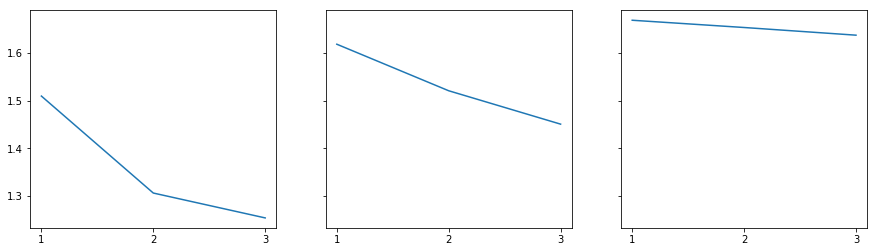

In [ ]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

The results above show that a learning rate of 0.1 is the best, though using such a high learning rate for the entire training is usually not a good idea. Thus, we should use **learning rate decay** - starting from a high learning rate and decaying it with every epoch.

We use another **custom callback** (`DecayLR`) to decay the learning rate at the end of every epoch. The decay rate is specified as 0.5 ^ epoch. Also, note that this time we are telling the model to **use two callbacks** (passed as a list `callbacks=[history, decay]` to `model.fit_generator`).


Although we have used out own custom decay implementation here, you can use the ones built into <a href="https://keras.io/optimizers/">keras optimisers</a> (using the `decay` argument).

In [ ]:
# learning rate decay
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(tf.keras.backend.get_value(self.model.optimizer.lr))
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)

# to store loss history
history = LossHistory()
plot_data = {}

# start with lr=0.1
decay = DecayLR(base_lr=0.1)

# model
sgd = optimizers.SGD()
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[history, decay])

plot_data[lr] = decay.lr_history

Epoch 1/3
6/6 [==============================] - 2s 321ms/step - loss: 1.5159 - accuracy: 0.6927 - val_loss: 6.8833 - val_accuracy: 0.5156
Epoch 2/3
6/6 [==============================] - 1s 230ms/step - loss: 1.5227 - accuracy: 0.7865 - val_loss: 9.1820 - val_accuracy: 0.5469
Epoch 3/3
6/6 [==============================] - 1s 229ms/step - loss: 1.2654 - accuracy: 0.8490 - val_loss: 2.8214 - val_accuracy: 0.6354


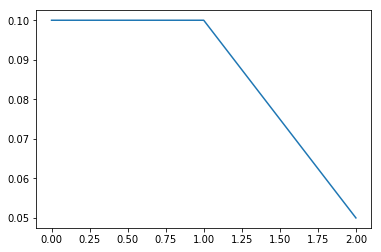

In [ ]:
plt.plot(np.arange(len(decay.lr_history)), decay.lr_history)

## Augmentation Techniques

Let's now write some code to implement data augmentation. Augmentation is usually done with data generators, i.e. the augmented data is generated batch-wise, on the fly. 

You can either use the built-in keras `ImageDataGenerator` or write your own data generator (for some custom features etc if you want). The two cells below show how to implement these respectively. 

In [ ]:
# keras data generator
# help(ImageDataGenerator)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

If you want to implement your own customized data generator (with augmentation), you can add the augmentation step easily to the `DataGenerator` class created above. The only change is that we stack the augmented images to the X, y arrays (as done in the last section of the code below).

In [ ]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
        

### Metrics to optimise
 <font color="red">
Here, the learning rate is set to decrease after every epoch as the dataset is small.  Typical values can be reducing the learning rate by a factor of 0.5 after every 5-10 epochs or by a factor of 0.1 every 20 epochs. Note that these numbers can differ significantly depending on the model and problem. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates (validation loss). 

 

 You also learnt that a sample of original image data is picked from the directory and an equal number of augmented data is generated by ImageDataGenerator (using keras method) by applying random transformations to original images. The original and the augmented images are combined to form 2x data and used for training.Rohit also pointed out that it is better to use AUC curve rather than accuracy metrics, especially if the dataset is skewed like in the case of the medical dataset where you have fewer samples of patients who actually have the disease.
 </font>

AUC is often a better metric than accuracy. So instead of optimising for accuracy, let's monitor AUC and choose the best model based on AUC on validaton data. We'll use the callbacks `on_train_begin` and `on_epoch_end` to initialise  (at the start of each epoch) and store the AUC (at the end of epoch).

**For binary classification problems, AUC is usually the best metric.**


 <font color="red">
Difference Between Precision and Accuracy
For instance:

A number that is not precise but accurate.
A number that is not accurate but precise.
A number that is precise and accurate.
Precision is the amount of information that is conveyed by a value. Whereas Accuracy is the measure of correctness of the value in correlation with the information.

Let’s consider the value of “pi”, i.e, 3.142857143.

According to the questions:

A number that is not precise but accurate is 3.14. It is accurate based on closeness and no other number with three digits can get closer to the target.

A number that is not accurate but precise is 1.1423345678901234567890. It is very precise as it conveys more information. But cannot be considered accurate because it’s not near the target.

A number that is precise and accurate is 3.142857143. It is the only number which has maximum accuracy and precision if the target value is 3.142857143.

AUC values
What is the worst value for AUC?


0 ✕ Incorrect
Feedback:
The value of 0 means that the model is assigning exactly the other class for each prediction.


1 ✕ Incorrect


0.5 ✓ Correct
Feedback:
0.5 means the model just cannot distinguish between classes.

 </font>
 <font color="blue">
    <HR><HR>
        
        Precision or Recall?
Let's say you want to create a model that predicts 0 or 1. The focus is to pick up all the values of 1 that there are in your prediction sample. Which of these is a better idea to maximise?


Precision

✕ Incorrect
Feedback:
Precision refers to "out of the total values predicted as positive, how many are actually positive"?


Recall

✓ Correct
Feedback:
Recall refers to "out of the total number of positive samples, how many are correctly identified"?
</font>

In [ ]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc


## Final Run

Let's now train the final model. Note that we will keep saving the best model's weights at `models/best_models.hdf5`, so you will need to create a directory `models`. Note that model weights are usually saved in hdf5 files.

**Saving the best model** is done using the callback functionality that comes with `ModelCheckpoint`. We basically specify the `filepath` where the model weights are to be saved, ` monitor='val_auc'` specifies that you are choosing the best model based on validation accuracy, `save_best_only=True` saves only the best weights, and `mode='max'` specifies that the validation accuracy is to be maximised.

In [ ]:
# model
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=32)
validation_generator = AugmentedDataGenerator('val', ablation=32)

# checkpoint 
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()

# fit
model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[auc_logger, history, decay, checkpoint])

Epoch 1/3
2/2 [==============================] - ETA: 0s - loss: 2.1315 - accuracy: 0.4375
Val AUC for epoch0: 0.51025390625

Epoch 00001: val_auc improved from -inf to 0.51025, saving model to models/best_model.hdf5
2/2 [==============================] - 2s 1s/step - loss: 2.1315 - accuracy: 0.4375 - val_loss: 26.2089 - val_accuracy: 0.5000 - val_auc: 0.5103
Epoch 2/3
2/2 [==============================] - ETA: 0s - loss: 2.0446 - accuracy: 0.6875
Val AUC for epoch1: 0.7900390625

Epoch 00002: val_auc improved from 0.51025 to 0.79004, saving model to models/best_model.hdf5
2/2 [==============================] - 1s 618ms/step - loss: 2.0446 - accuracy: 0.6875 - val_loss: 7.1659 - val_accuracy: 0.5000 - val_auc: 0.7900
Epoch 3/3
2/2 [==============================] - ETA: 0s - loss: 1.3234 - accuracy: 0.8594
Val AUC for epoch2: 0.817626953125

Epoch 00003: val_auc improved from 0.79004 to 0.81763, saving model to models/best_model.hdf5
2/2 [==============================] - 1s 612ms/ste

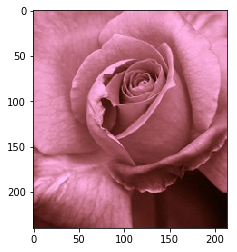

In [ ]:
plt.imshow(image)

In [ ]:
h, w, _ = image.shape
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]

model.predict(img[np.newaxis,: ])

array([[0., 1.]], dtype=float32)

### Summary

Data preprocessing
Morphological Transformations: This refers to changing the shape and size of images. The typical transformations are erosion, dilation, opening and closing. 

 

Augmentation: Refers to making changes related to rotation, translation, shearing, etc. Augmentation is often used in image-based deep learning tasks to increase the amount and variance of training data. Augmentation should only be done on the training set, never on the validation set.

 

Normalisation: Refers to rescaling the pixel values so that they lie within a confined range. One of the reasons to do this is to help with the issue of propagating gradients.

 

 

Network building
Choosing the architecture: For this demo, we used the 'ResNet' architecture. Its biggest upside is that the 'skip connections' mechanism allows very deep networks.

 

Ablation Experiments: These refer to taking a small chunk of data and running your model on it - this helps in figuring out if the model is running at all.

 

Overfitting on Training Data: This tells you whether the model is behaving as expected or not.

 

Metrics: Depending on the situation, we choose the appropriate metrics. For binary classification problems, AUC is usually the best metric.

 

Hyperparameter tuning: We tune hyperparameters such as the learning rate, augmentation of images, batch size, etc. Also, we only change the architecture of the network if we have already tried tuning all other hyperparameters.



